# Lesson 14 Regression: Understand the Models

**Regularization** was useful to improve ML models, or at least that's the goal.  

We noticed, regularization did not dramatically increase the $R2$ score of the fit all that much. In this section, we will cover the inner workings of exactly that.  

Once we fit the models, we can also look at the weights generated by the various model types. 

\begin{align}
    \text{Linear: } min_w ||y - Xw||_2^2 \\[0.25cm]
    \text{Ridge: } min_w ||y - Xw||_2^2 + \lambda ||w||_2^2 \\[0.25cm]
    \text{Lasso: } min_w ||y - Xw||_2^2 + \lambda ||w||_1^1 
\end{align}

We can visualize through a heat map to compare them easily.  

We do some <mark>**data scaling**</mark> here to prevent an imbalanced data set where categories with larger values carry heavier weight.  

We re-apply the regression types: linear, ridge, and lasso to the scaled data and compare to the original results.  

<mark>**One-hot encoding**</mark> is used to convert <mark>categorical variables</mark> to aform usable by ML algos. This is done by creating a column for each category and creating a 1-0 relationship indicating what category each row of data belongs to. Example: instead of Yes, No for a categorical variable, there will be two new columns "Yes" and "No" and each row will have either [1, 0] or [0, 1] depending on what category that row of data belongs to.   

We will apply the regression methods after one-hot encoding is applied.  We will observe the fits have not improved at all without regularization. 

We will apply regularized regression methods after one-hot encoding is applied.



# Imports

In [1]:
%cd ..

/Users/jaimemerizalde/Desktop/Library/Machine Learning Udemy Course


In [2]:
from Library import data
import pandas as pd
import numpy as np

import csv

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from yellowbrick.regressor import AlphaSelection, prediction_error, residuals_plot


# Get Data

In [4]:
df = data.get_data("Datasets/LifeExpectancy.csv", index_col=[0])
df

# Preprocess
categorical_columns = list(df.dtypes[df.dtypes=="O"].index.values)
categorical_columns

for col in categorical_columns:
    df[col] = df[col].astype("category")
df.drop(columns=categorical_columns, inplace=True)

X = df.loc[:, df.columns != "life_expectancy"]
y = df["life_expectancy"]

# Train test split"
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.33, random_state=42)

# Get Weights

We can rerun the analysis here or better yet, we can capture / save the analysis from its origins, then pull it in here.  

In [5]:
filepath = "Lesson 13 - Lasso Regression/lasso_cv_weights.csv"
lasso_cv_weights = data.load_weights(filepath)

filepath = "Lesson 12 - Ridge Regression/ridge_cv_weights.csv"
ridge_cv_weights = data.load_weights(filepath)

filepath = "Lesson 11 - Linear Regression/linear_regression_weights.csv"
linear_cv_weights = data.load_weights(filepath)

# Place in a dataframe.
weights = pd.DataFrame(
    {
        "linear": linear_cv_weights, 
        "ridge": ridge_cv_weights, 
        "lasso": lasso_cv_weights
    }, 
    index=X_train.columns # We have this here so we can call the data by the same name of how it appears in the original df.
)
weights.T

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
linear,-0.129179,-0.015504,0.109459,-0.099266,0.000470,-0.003087,-0.000021,0.023068,-0.079611,-0.001957,0.027271,0.015834,-0.448470,0.000003,-1.081427e-09,0.001099,-0.092011,10.140044,1.023914
ridge,-0.138838,-0.016472,0.098495,-0.115513,0.000311,-0.003963,-0.000020,0.026406,-0.071689,0.001376,0.059479,0.014371,-0.445590,0.000027,-3.213065e-09,-0.012716,-0.083056,10.672488,0.951866
lasso,-0.138934,-0.016475,0.098054,-0.115730,0.000311,-0.003958,-0.000020,0.026415,-0.071377,0.001380,0.059448,0.014384,-0.445613,0.000027,-3.189428e-09,-0.012691,-0.082986,10.675074,0.951954


# Visualizing Weights for Comparison

We will visualize using a heatmap here.

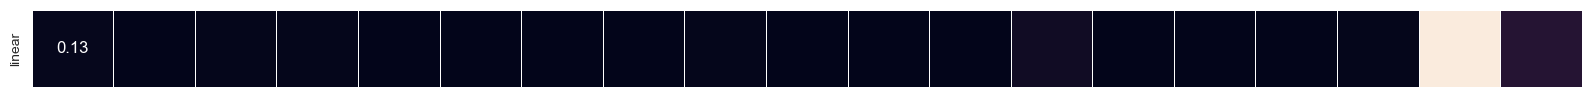

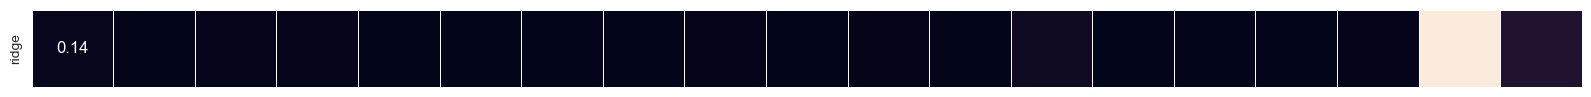

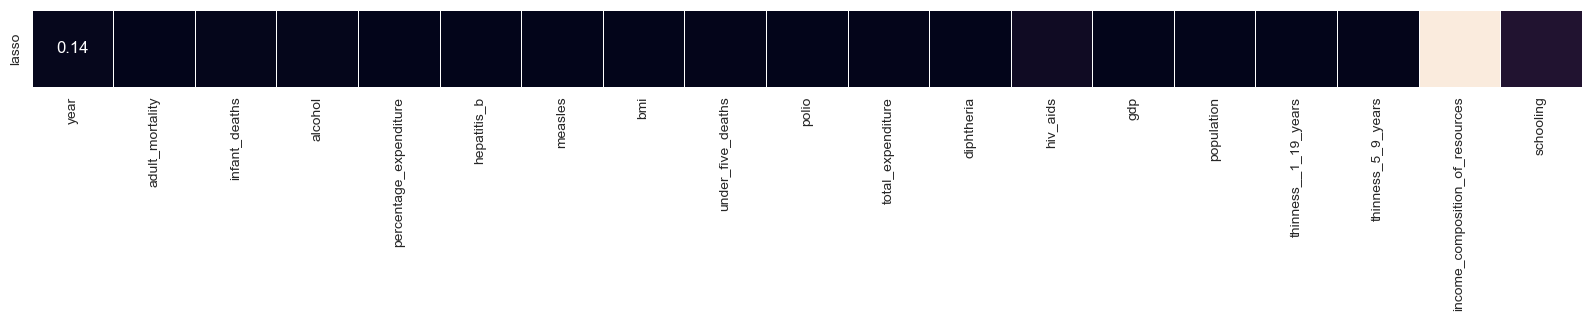

In [8]:
fig, ax = plt.subplots(figsize=(20, 1));

sns.heatmap(
    weights.T.loc[["linear"],:].abs(), 
    annot=True, linewidth=0.5, ax=ax, cbar=False,
    xticklabels=False
)
plt.figure(figsize=(20, 1))
sns.heatmap(
    weights.T.loc[["ridge"],:].abs(), 
    annot=True, linewidth=0.5, cbar=False,
    xticklabels=False
)
plt.figure(figsize=(20, 1))
sns.heatmap(
    weights.T.loc[["lasso"],:].abs(), 
    annot=True, linewidth=0.5, cbar=False,
    xticklabels=True
)

plt.show()

We can also visualize the 'X_train mean' as well. 

It may not be obvious since this backend is not doing so well, but there are a range of values here in the heatmap. There is a white-hot variable, and by comparison, everything else is a lot colder. 

The main idea here is then to SCALE the models so each feature / columns is not being weighted to heavily simply because of the size of the elements.

<Axes: >

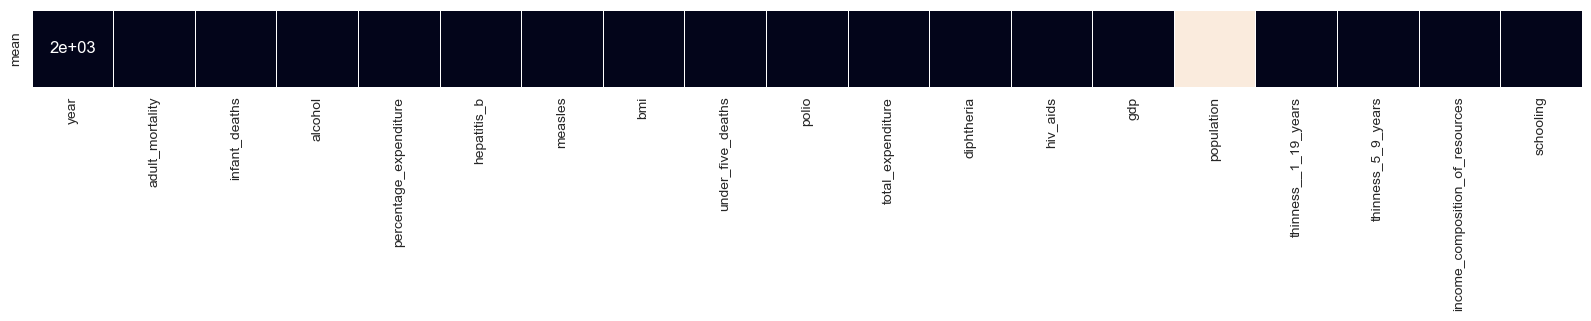

In [9]:
plt.figure(figsize=(20, 1))
sns.heatmap(
    X_train.mean().to_frame().T.rename(index={0: "mean"}), 
    annot=True, linewidth=0.5, cbar=False, xticklabels=True
)

# Scaling Data

Goal is to have all variables witht he same range. I'm using a custom data scaler from data.py in my library. Notice this scaling here is done on JUST the training data. The scaler has not been calibrated for the test data.

In [10]:
# NOTE: this will drop non-numerical columns and nans.
X_train, y_train, scaler = data.scale_data(X_train, y_train)
X_test, y_test, _ = data.scale_data(X_test, y_test, scaler=scaler) 

Original Size X: (1968, 19) y: (1968,)
Removed []
New Size X: (1123, 19) y: (1123,)
Original Size X: (970, 19) y: (970,)
Removed []
New Size X: (526, 19) y: (526,)


Preview how the values look now. Now look at this and see how much more smoothly values are distributed. 

<Axes: >

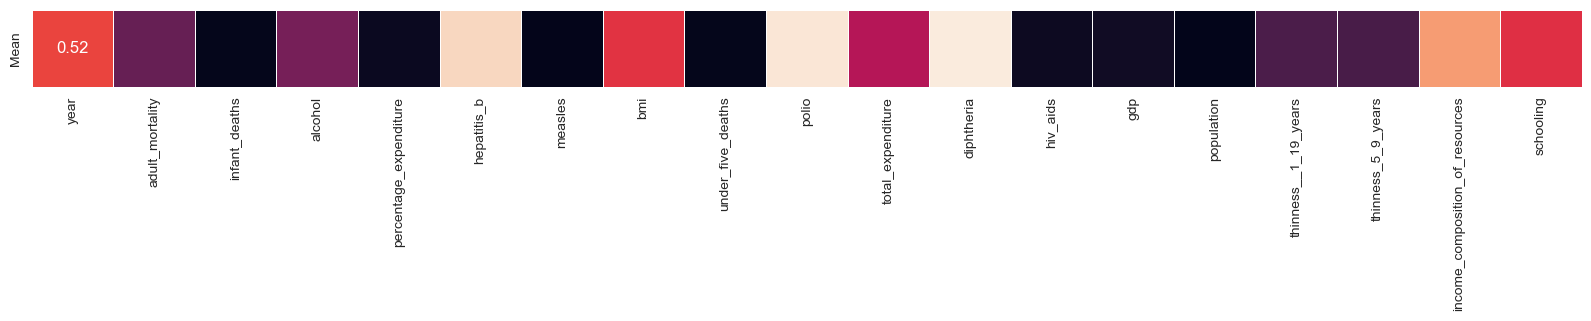

In [11]:
plt.figure(figsize=(20, 1))

sns.heatmap(
    X_train.mean().to_frame().T.rename(index={0: "Mean"}), 
    annot=True, linewidth=0.5, cbar=False, xticklabels=True
)

# Apply Regression to Scaled Data

In [ ]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV 
from sklearn.model_selection import cross_val_score

lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 10, 50, 100]

linear_scaled = LinearRegression().fit(X_train, y_train)
ridge_cv_scaled = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train,)
lasso_cv_scaled = LassoCV(alphas=lambdas, cv=5).fit(X_train, y_train)

# Perform cross validation score checking.
r2_linear_scaled = np.mean(cross_val_score(linear_scaled, X_train, y_train, cv=5, scoring="r2"))
r2_ridge_scaled = np.mean(cross_val_score(ridge_cv_scaled, X_train, y_train, cv=5, scoring="r2"))
r2_lasso_scaled = np.mean(cross_val_score(lasso_cv_scaled, X_train, y_train, cv=5, scoring="r2"))

# Store the computed weights in a dataframe.
weigths = pd.DataFrame({"linear_scaled": linear_scaled.coef_, "ridge_scaled": ridge_cv_scaled.coef_, "lasso_scaled": lasso_cv_scaled.coef_}, index=X_train.columns)



/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.51154448309535, tolerance: 6.63787823719376
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.217559168804655, tolerance: 6.63787823719376
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.7506262515235, tolerance: 7.180712988864145
  model = cd_fast.enet_c

We can see the weights are the same across all the modes of regression, with the exception of possibly thinness, but eeven then it is still small. 

In [ ]:
weights.T

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
linear,-0.129179,-0.015504,0.109459,-0.099266,0.000470,-0.003087,-0.000021,0.023068,-0.079611,-0.001957,0.027271,0.015834,-0.448470,0.000003,-1.081427e-09,0.001099,-0.092011,10.140044,1.023914
ridge,-0.138838,-0.016472,0.098495,-0.115513,0.000311,-0.003963,-0.000020,0.026406,-0.071689,0.001376,0.059479,0.014371,-0.445590,0.000027,-3.213065e-09,-0.012716,-0.083056,10.672488,0.951866
lasso,-0.138934,-0.016475,0.098054,-0.115730,0.000311,-0.003958,-0.000020,0.026415,-0.071377,0.001380,0.059448,0.014384,-0.445613,0.000027,-3.189428e-09,-0.012691,-0.082986,10.675074,0.951954


Taking a look at the $R-squared$ values. Notice the Ridge regressoin scaled is now doing worse than the Linear scaled, albeit marginally. The lasso scaled is doing the best, but again, only just barely, according to the $R2$ score.

In [14]:
r2_results = pd.DataFrame({"linear_r2_scaled": r2_linear_scaled, "ridge_r2_scaled" : r2_ridge_scaled, "lasso_r2_scaled": r2_lasso_scaled}, index=["CV R2"])
r2_results

,linear_r2_scaled,ridge_r2_scaled,lasso_r2_scaled
CV R2,0.818749,0.818702,0.818842


# One-Hot Encoding

We will create a pre-processing method so we can create this one-hot encoding.  

this preprocessing was added to the `data` code repository.

In [15]:
# Get data again. We need the cat vars this time.
df = data.get_data("Datasets/LifeExpectancy.csv", index_col=[0])
df

# Preprocess
categorical_columns = list(df.dtypes[df.dtypes=="O"].index.values)
categorical_columns

for col in categorical_columns:
    df[col] = df[col].astype("category")

X = df.loc[:, df.columns != "life_expectancy"]
y = df["life_expectancy"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Apply One-Hot Encoding.
X_train, y_train, scaler = data.one_hot_encoding_preprocessing(X_train, y_train, scaler=None)
X_test, y_test, scaler = data.one_hot_encoding_preprocessing(X_test, y_test, scaler=None)


Original Size X: (1968, 21) y: (1968,)
New Size X: (1123, 214) y: (1123,)
Original Size X: (970, 21) y: (970,)
New Size X: (526, 214) y: (526,)


# Apply Regression after Scaling and One-Hot Encoding

We can apply this to linear regression w and without cross validation. Notice for CV, there is a **LARGE NEGATIVE VALUE** which is much outside the range.  

It means the model cannot generalize if we want to use it on new data.  

The causes may be **overfitting** the training data. So we are too tied to the training data, but inflexible for new or test data.  

Could be **curse of dimensionality** we have 214 variables for 1123 samples. We have a LOT of dimensions to work with now for the optimization problems our algorithms will face.  

We visualize this as well as a heatmap.

We can see we are overfitting the datas because we are overfitting. You can see from the map that many variables have 0 weight, whill some varialbes have extremely high weight O(1e11). We have too much confidence in very few of the variables and no confidence everywhere else.

In [ ]:
# This renaming was being done because we imported from the auxillary notebook.
X_train_one_hot = X_train
y_train_one_hot = y_train

linear_one_hot = LinearRegression().fit(X_train_one_hot, y_train_one_hot)
r2_linear_one_hot = linear_one_hot.score(X_train_one_hot, y_train_one_hot)
r2_linear_one_hot_cv = np.mean(cross_val_score(linear_one_hot, X_train_one_hot, y_train_one_hot, cv=5, scoring="r2"))

lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 10, 50, 100]
ridge_one_hot = RidgeCV(alphas=lambdas, cv=5).fit(X_train_one_hot, y_train_one_hot)
r2_ridge_one_hot = ridge_one_hot.score(X_train_one_hot, y_train_one_hot)
r2_ridge_one_hot_cv = np.mean(cross_val_score(ridge_one_hot, X_train_one_hot, y_train_one_hot, cv=5, scoring="r2"))

lasso_one_hot = LassoCV(alphas=lambdas, cv=5).fit(X_train_one_hot, y_train_one_hot)
r2_lasso_one_hot = lasso_one_hot.score(X_train_one_hot, y_train_one_hot)
r2_lasso_one_hot_cv = np.mean(cross_val_score(lasso_one_hot, X_train_one_hot, y_train_one_hot, cv=5, scoring="r2"))

/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.32869841111392, tolerance: 6.63787823719376
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 952.1435637808772, tolerance: 6.63787823719376
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.59515464239166, tolerance: 7.286536517817368
  model = cd_fast.enet_c

In [19]:
print(f"r2_linear_one_hot: {r2_linear_one_hot}\n\tr2_linear_one_hot_cv: {r2_linear_one_hot_cv}")
print(f"r2_ridge_one_hot: {r2_ridge_one_hot}\n\tr2_ridge_one_hot_cv: {r2_ridge_one_hot_cv}")
print(f"r2_lasso_one-hot: {r2_lasso_one_hot}\n\tr2_lasso_one_hot_cv: {r2_lasso_one_hot_cv}")


r2_linear_one_hot: 0.9662965420137418
	r2_linear_one_hot_cv: -3.859943738436844e+21
r2_ridge_one_hot: 0.9662007339787714
	r2_ridge_one_hot_cv: 0.9505632750116456
r2_lasso_one-hot: 0.9659831378445407
	r2_lasso_one_hot_cv: 0.949567393843233



# Regularization (post One-Hot Encoding)

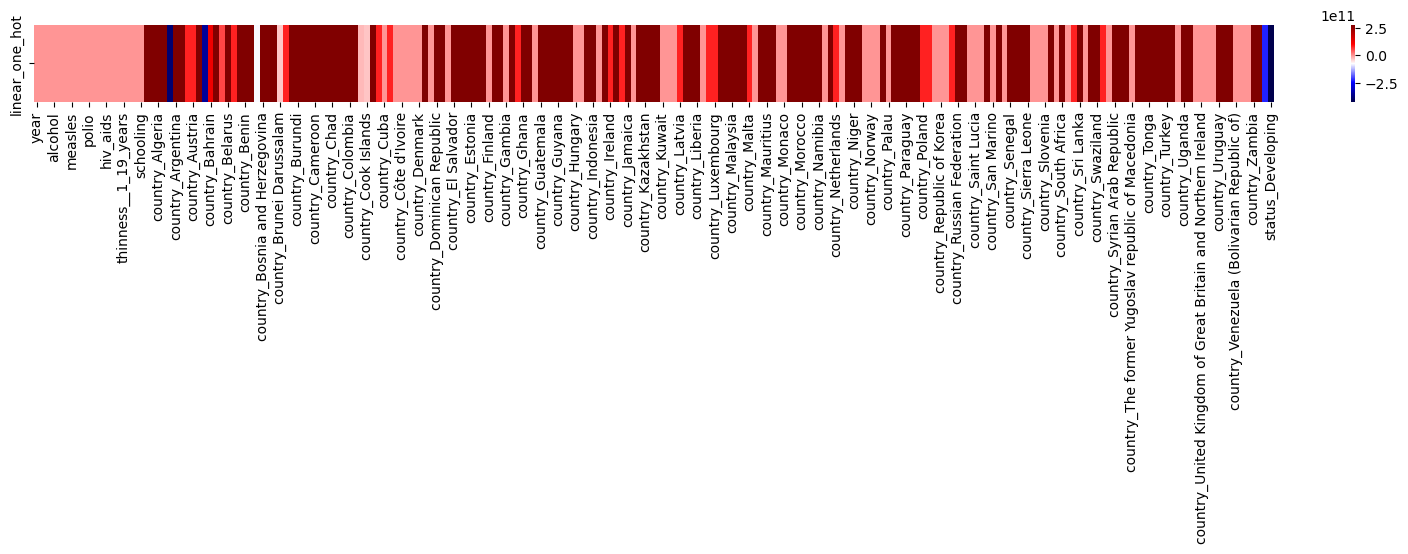

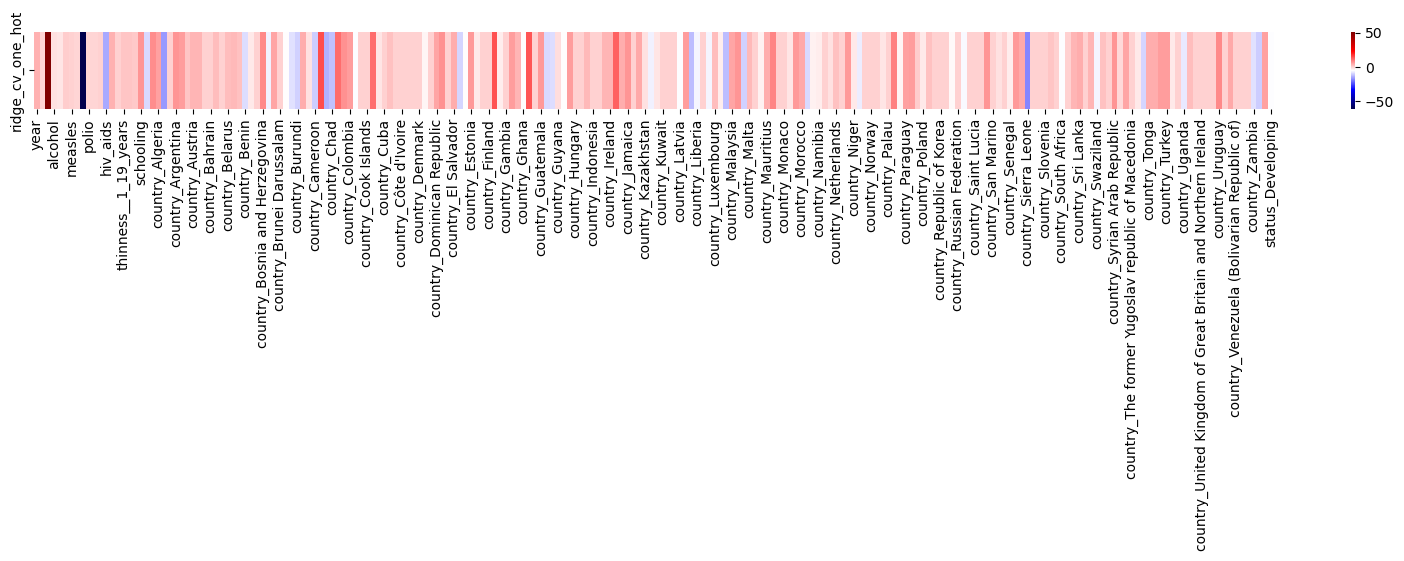

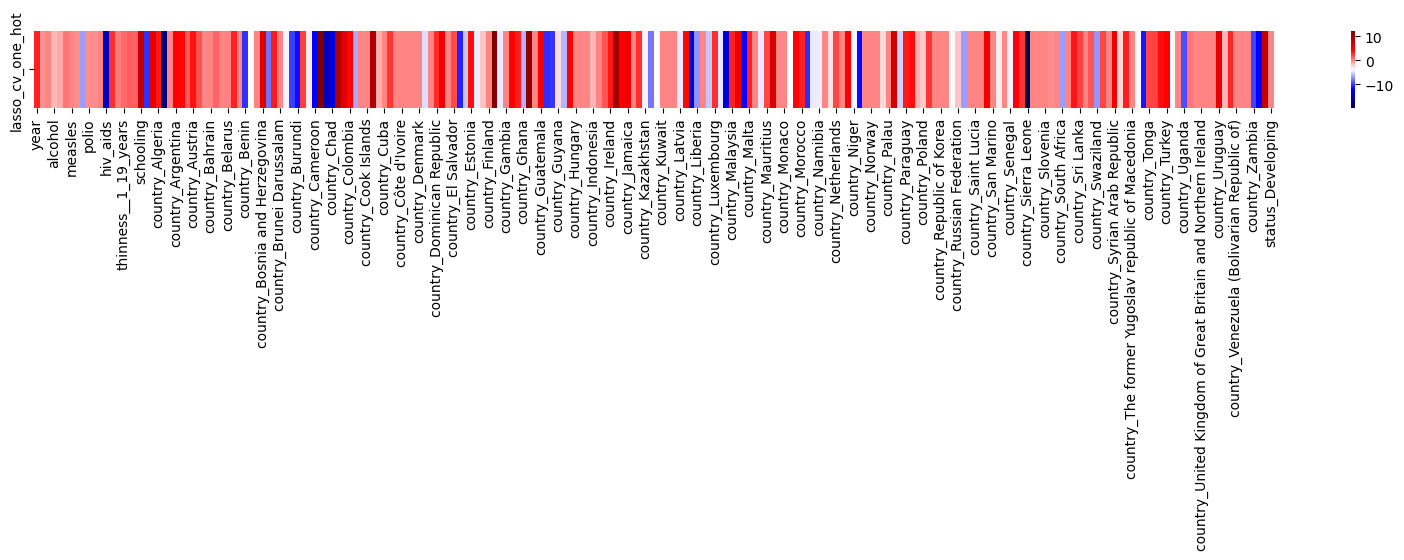

In [41]:
# Start with Ridge Regression w One-Hot
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 10, 50, 100]

# ridge_cv_one_hot = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train)
# r2_ridge_one_hot_train = ridge_cv_one_hot.score(X_train, y_train)
# r2_ridge_one_hot_cv = np.mean(cross_val_score(ridge_cv_one_hot, X_train, y_train, cv=5, scoring="r2"))

# # Now do it with lasso
# lasso_cv_one_hot = LassoCV(alphas=lambdas, cv=5).fit(X_train, y_train)
# r2_lasso_one_hot_train =  lasso_cv_one_hot.score(X_train, y_train)
# r2_lasso_one_hot_cv = np.mean(cross_val_score(lasso_cv_one_hot, X_train, y_train, cv=5, scoring="r2"))

# Now put the weights in a dataframe.
weights = pd.DataFrame(
    {
        "linear_one_hot": linear_one_hot.coef_,
        "ridge_cv_one_hot": ridge_cv_one_hot.coef_,
        "lasso_cv_one_hot": lasso_cv_one_hot.coef_,
    },
    index=X_train.columns
)

# Easier to see as a transpose.
weights.T

# Now plot them for comparison
for column in weights.columns:
    fig = plt.figure(figsize=(20, 1))
    sns.heatmap(weights[[column]].T, cmap="seismic")

# Discussion for One-Hot w Regularization

We can see that compared to the original linear regression without regularization, the one-hot encoding with regularization and with cross validation (as is typical), is no longer suffering from overfitting. We have regularized the space so we penalize using too many weights. In particular, the lasso regression, aka, $L^1$ regression, has nicely-distributed weights compared to its $L^2$ (ridge) counterpart. However, $L^1$ r2 score is 0.9486 versus 0.9662 for $L^2$.

# Comparing to previous, scaling only R-squared scores

All together, we can see how much better One-Hot encoding with regularization (and cv for testing/verifying) is showing that we have quite good results with using regularization. The cross validation really makes this stand out.

In [20]:
# Get the previous results:
r2_results

# Add the current results:
r2_results.loc[:, "linear_One_Hot"] = [r2_linear_one_hot_cv]
r2_results.loc[:, "ridge_One_Hot"] = [r2_ridge_one_hot_cv]
r2_results.loc[:, "lasso_One_Hot"] = [r2_lasso_one_hot_cv]

# print
r2_results

,linear_r2_scaled,ridge_r2_scaled,lasso_r2_scaled,linear_One_Hot,ridge_One_Hot,lasso_One_Hot
CV R2,0.818749,0.818702,0.818842,-3.859944e+21,0.950563,0.949567


# Predictions on Test Data

Now we can use our trained cross validated one-hot encoded models and data on the TEST data. This we can gauge for the utility of these models.  

We have that there are models here we can see these do well on the test data (data these models have not seen before at all). This means we have quite a good fit. A good way to look at this as well is to include the norm mse. It is quite low, so much of the variance is explained by the model.

In [22]:
# Ridge
X_test_one_hot = X_test
y_test_one_hot = y_test

y_test_hat = ridge_one_hot.predict(X_test_one_hot)
r2_ridge_test = ridge_one_hot.score(X_test_one_hot, y_test_one_hot)
mse_ridge_test = mean_squared_error(y_test_one_hot, y_test_hat)
norm_mse_ridge_test = 1 - r2_ridge_test
print(f"Mean squared error test ridge: {mse_ridge_test}\nr2_ridge_test: {r2_ridge_test}\nnorm_mse_ridge_test: {norm_mse_ridge_test}")

# Lasso
y_test_hat = lasso_one_hot.predict(X_test_one_hot)
r2_lasso_test = lasso_one_hot.score(X_test_one_hot, y_test_one_hot)
mse_lasso_test = mean_squared_error(y_test_one_hot, y_test_hat)
norm_mse_lasso_test = 1 - r2_lasso_test
print(f"Mean squared error test lasso: {mse_lasso_test}\nr2_lasso_test: {r2_lasso_test}\nnorm_mse_lasso_test: {norm_mse_lasso_test}")


Mean squared error test ridge: 2.5788647327781353
r2_ridge_test: 0.9652189715336724
norm_mse_ridge_test: 0.03478102846632758
Mean squared error test lasso: 2.5857618131518865
r2_lasso_test: 0.9651259509321012
norm_mse_lasso_test: 0.034874049067898816


# Visualizing

We can visuazlie w qq plots, prediction errors, and residual errors.  

We can see the fit is quite good with $R^2 = 0.965$.

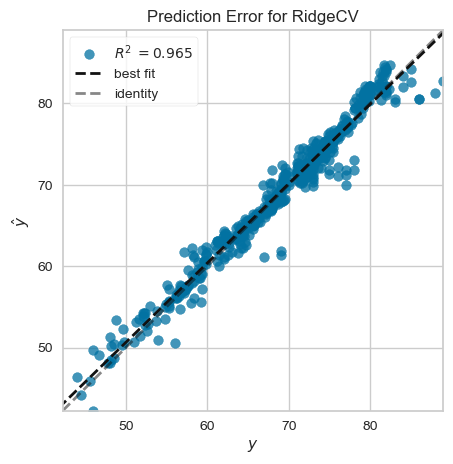

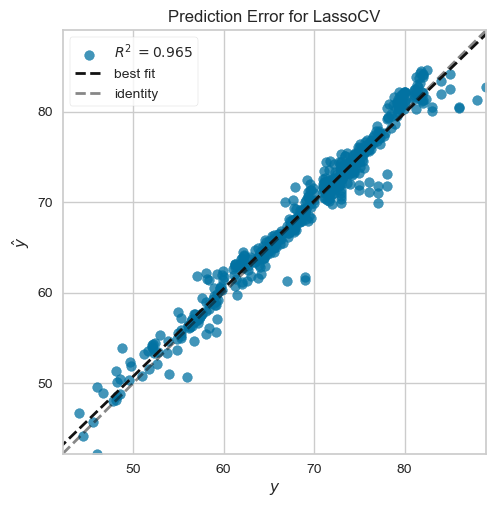

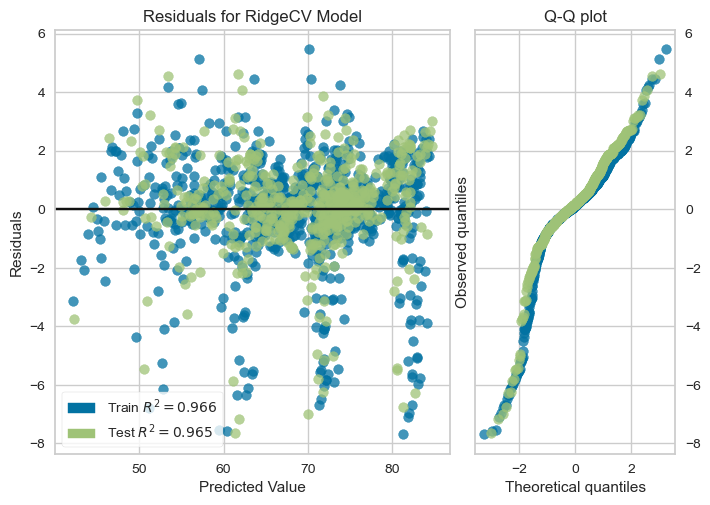

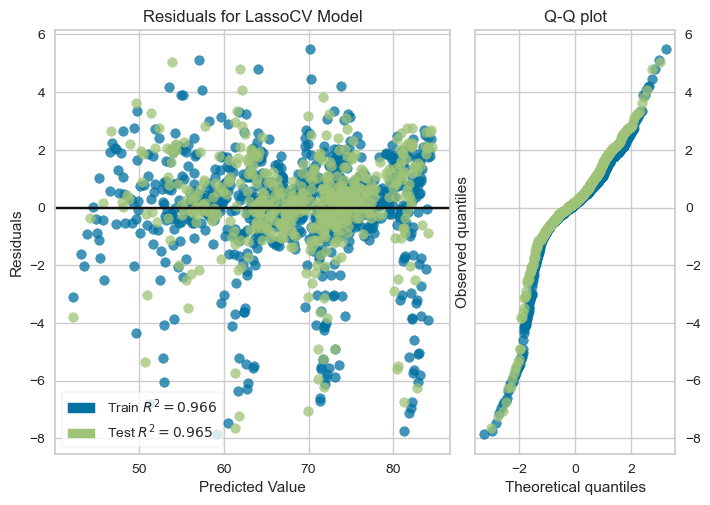

In [23]:
plt.figure(figsize=(8, 8 / 1.618));

# Prediction Error 
visualizer = prediction_error(ridge_one_hot, X_test_one_hot, y_test_one_hot, is_fitted=True)
visualizer = prediction_error(lasso_one_hot, X_test_one_hot, y_test_one_hot, is_fitted=True)

# Residuals PLot
visualizer = residuals_plot(
    ridge_one_hot, 
    X_train_one_hot, y_train_one_hot, 
    X_test_one_hot, y_test_one_hot, 
    is_fitted=True, qqplot=True, hist=False
)
visualizer = residuals_plot(
    lasso_one_hot, 
    X_train_one_hot, y_train_one_hot, 
    X_test_one_hot, y_test_one_hot, 
    is_fitted=True, qqplot=True, hist=False
)